In [1]:
import os
import datetime
from importlib import reload

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

from helpers import *

%matplotlib inline
pd.options.display.max_columns = 150

In [75]:
from helpers import *

# Main Analysis
All data transformations and modeling used in final approach is stored here. Unsuccessful attempts are store in [file]
## Build Base Dataframe

In [3]:
team_key = {
    'Chicago Cubs':'CHC',
    'St. Louis Cardinals':'STL',
    'Colorado Rockies': 'COL',
    'Washington Nationals': 'WSN',
    'Minnesota Twins': 'MIN',
    'San Francisco Giants': 'SFG',
    'Boston Red Sox': 'BOS',
    'Toronto Blue Jays': 'TOR',
    'New York Yankees': 'NYY',
    'Seattle Mariners': 'SEA',
    'Atlanta Braves': 'ATL',
    'Baltimore Orioles': 'BAL',
    'Milwaukee Brewers': 'MIL',
    'Philadelphia Phillies': 'PHI',
    'Arizona Diamondbacks': 'ARI',
    'Chicago White Sox': 'CHW',
    'Cincinnati Reds': 'CIN',
    'San Diego Padres':'SDP',
    'Texas Rangers': 'TEX',
    'Los Angeles Angels': 'LAA',
    'Oakland Athletics':'OAK',
    'Tampa Bay Rays': 'TBR',
    'Miami Marlins': 'MIA',
    'Houston Astros': 'HOU',
    'New York Mets': 'NYM',
    'Pittsburgh Pirates': 'PIT',
    'Detroit Tigers': 'DET',
    'Cleveland Indians': 'CLE',
    'Kansas City Royals': 'KCR',
    'Los Angeles Dodgers': 'LAD',
}

# load all game info
matchups_long = pd.read_csv('matchups_long.csv', parse_dates=['date'])
matchups_long.drop('Unnamed: 0', axis = 1, inplace = True)

# date_m1 is used to match statistics
# must match on the day before the game
matchups_long['date_m1'] = matchups_long.date - datetime.timedelta(days = 1)

# drop all star games and double headers
matchups_long = matchups_long[matchups_long.team != 'National League All-Stars']
matchups_long = matchups_long[matchups_long.team != 'American League All-Stars']
matchups_long['team_fg'] = matchups_long.team.apply(lambda x: team_key[x])
matchups_long['opp_team_fg'] = matchups_long.opp_team.apply(lambda x: team_key[x])
matchups_long.drop_duplicates(subset = ['date', 'team_fg', 'opp_team_fg'], inplace = True)

# merge in result of game's at bats (dependent variable)
temp_df = load_data('hitting/results_master','results')
left_variables = ['results__Date','results__Name','results__Team']
temp_df.drop_duplicates(subset=left_variables, inplace = True)
left_variables = ['results__Date','results__Team']
matchups_long = pd.merge(temp_df, matchups_long,
               how = 'left',
               left_on = left_variables,
               right_on = ['date','team_fg'])
matchups_long['got_hit'] = matchups_long.results__AVG > 0
cols = [x for x in matchups_long.columns if not x.startswith('results__')] + ['results__Name']
matchups_long = matchups_long[cols]
matchups_long.rename(columns = {'results__Name': 'name'}, inplace = True)
matchups_long.dropna(inplace = True)

# shuffle and split out model sets
matchups_long = shuffle(matchups_long)
size = len(matchups_long)
model_set = ['train'] * int(size *.5)
model_set += ['dev'] * int(size *.4)
model_set += ['test'] * (size - len(model_set))
matchups_long['model_set'] = model_set
matchups_long['fs_id'] = list(range(0,size))

matchups_long.to_csv('data/analysis_1_.csv', index = False)

## Previous Hit Consistency
Percent that a batter gets at least one hit in game. 

In [130]:
df = load_analysis_set(1)

In [140]:
# load dataset
df_hits = load_data('hitting/results_master','results')
right = ['results__Date','results__Name','results__Team']
df_hits.drop_duplicates(subset = right, inplace = True)
df_hits = df_hits[df_hits.results__G == 1]
df_hits['hit'] = df_hits.results__H > 0
df_hits.sort_values('results__Date', inplace = True)

# calculate cumulative average of getting a hit
gb = ['results__Season', 'results__Team','results__Name']
cols = ['results__G', 'hit']
df_gb = df_hits[gb + cols].groupby(gb).cumsum()
df_gb.rename(columns={'hit': 'hitbin_hit_cum', 'results__G': 'hitbin_g_cum'}, inplace = True)
cols = ['hitbin_hit_cum', 'hitbin_g_cum']
df_hits = pd.concat([df_hits, pd.concat([df_hits, df_gb], axis = 1)[gb + cols].groupby(gb).shift()], axis = 1)
df_hits['hitbin_avg_cum'] = df_hits.hitbin_hit_cum / df_hits.hitbin_g_cum
df_hits.drop('hitbin_hit_cum', axis = 1, inplace = True)

def drop_small_sample(row):
    """Fill avg with games < 10 with nan"""
    try:
        if row.hitbin_g_cum < 10:
            return np.nan
        else:
            return row.hitbin_avg_cum
    except:
        return np.nan
df_hits['hitbin_avg_cum'] = df_hits.apply(drop_small_sample, axis = 1)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


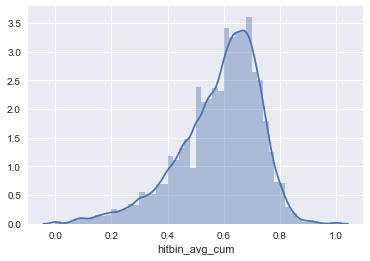

In [142]:
sns.distplot(df_hits.hitbin_avg_cum.dropna())

In [143]:
# calculate rolling averages for hit binary statistic
def concat_window(df_hits, window):
    """Calculates average hit binary for specified window length
    
    Args:
        df_hits: dataframe to calculate
        window: int. Number of games to go back
    
    Returns:
        df_hits with rolling average concatenated as last col
    """
    # calculate rolling average
    gb = ['results__Season', 'results__Team','results__Name']
    cols = ['hit']
    df_gb = df_hits[gb + cols].groupby(gb).rolling(window).mean()
    df_gb = df_gb.drop(gb, axis = 1).reset_index().set_index('level_3').drop(gb, axis = 1)
    cols = ['hitbin_avg_p' + str(window)]
    df_gb.columns = cols
    
    # shift rolling average and concatenate
    df_gb = pd.concat([df_hits, df_gb], axis = 1)[gb + cols].groupby(gb).shift()
    df_gb = pd.concat([df_hits, df_gb], axis = 1)
    return df_gb

df_hits = concat_window(df_hits, 7)
df_hits = concat_window(df_hits, 21)

# merge with main df
columns = df_hits.columns[-4:].tolist()
columns += ['results__Date', 'results__Team','results__Name']
df_hits = df_hits[columns]
df_hits.rename(columns = {'results__Date':'date', 
                          'results__Team':'team_fg',
                          'results__Name':'name'}, 
               inplace = True)
df = pd.merge(df, df_hits, how = 'left', on = ['name', 'date', 'team_fg'])

# drop batters with less than 10 games
# drops about 16% of rows
df.dropna(subset = ['hitbin_avg_cum'], inplace = True)
df.hitbin_avg_p21.fillna(df.hitbin_avg_p7, inplace = True)

In [144]:
# baseline
m = df.model_set == 'dev'
t = random_predictions(df)
print(metrics.classification_report(y_pred=t, y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.420     0.419     0.419     21471
       True      0.582     0.583     0.583     29834

avg / total      0.514     0.514     0.514     51305



In [145]:
features = [x for x in df.columns if x not in not_features]
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=75, max_features=None)
m = df.model_set == 'train'
rfc.fit(df.loc[m,features], df[m]['got_hit'])
m = df.model_set == 'dev'
dev_probs = rfc.predict_proba(df.loc[m,features])[:,1]

In [146]:
# random forest. 7% improvement over baseline
thresh = np.percentile(dev_probs, 50)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.481     0.574     0.523     21471
       True      0.644     0.553     0.595     29834

avg / total      0.575     0.562     0.565     51305



C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


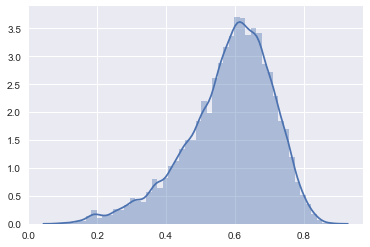

In [166]:
sns.distplot(dev_probs)

In [147]:
df.to_csv('data/analysis_2_.csv', index = False)

## Pitching: Hits Let Up
For each game, get percent of unique batters faced in which at least one hit was allowed

In [312]:
df = load_analysis_set(2)

In [313]:
# load hits dataset
# is not specific to starting pitcher (could have gotten hit off of bullpen)
# but will have to do
df_hits = load_data('hitting/results_master','results')
right = ['results__Date','results__Name','results__Team']
df_hits.drop_duplicates(subset = right, inplace = True)
df_hits = df_hits[df_hits.results__G == 1]
df_hits['hit'] = df_hits.results__H > 0
df_hits.sort_values('results__Date', inplace = True)
df_hits = df_hits[df_hits.results__PA > 1]

# calculate percent of batters not shut out per game
matchups = load_analysis_set(1)
cols = ['date', 'opp_pitcher', 'team_fg', 'opp_team_fg', 'home', 'name']
df_hits.rename(columns={'results__Team': 'team_fg', 
                        'results__Date': 'date', 
                        'results__Name':'name'}, inplace = True)
df_hits = pd.merge(df_hits, matchups[cols], how = 'left', on = ['date','team_fg', 'name'])
gb = ['date', 'opp_team_fg']
df_hit_pct = df_hits.groupby(gb).agg({'hit':'sum', 'home':'size'})
df_hit_pct['hit_pct'] = df_hit_pct.hit/df_hit_pct.home
df_hit_pct = df_hit_pct[['hit_pct']].reset_index()
df_hits = pd.merge(df_hits, df_hit_pct, how = 'left', on = ['date', 'opp_team_fg'])

# determine if pitcher position batted in game
def pitcher_bats(row):
    team_key = {
        'CHC': 1,
        'STL': 1,
        'COL': 1,
        'WSN': 1,
        'MIN': 0,
        'SFG': 1,
        'BOS': 0,
        'TOR': 0,
        'NYY': 0,
        'SEA': 0,
        'ATL': 1,
        'BAL': 0,
        'MIL': 1,
        'PHI': 1,
        'ARI': 1,
        'CHW': 0,
        'CIN': 1,
        'SDP': 1,
        'TEX': 0,
        'LAA': 0,
        'OAK': 0,
        'TBR': 0,
        'MIA': 1,
        'HOU': 0,
        'NYM': 1,
        'PIT': 1,
        'DET': 0,
        'CLE': 0,
        'KCR': 0,
        'LAD': 1,
    }
    try:
        if row['home']:
            return team_key[row['team_fg']]
        else:
            return team_key[row['opp_team_fg']]
    except:
        return np.nan
df_hits['pitcher_bats'] = df_hits.apply(pitcher_bats, axis = 1)
df_hits.sort_values('date', inplace = True)

# calculate cumulative average of getting a hit off of pitcher
gb = ['results__Season', 'opp_team_fg','opp_pitcher']
df_hits.drop_duplicates(gb + ['date'], inplace = True)
cols = ['results__G', 'hit_pct']
df_gb = df_hits[gb + cols].groupby(gb).cumsum()
df_gb.rename(columns={'hit_pct': 'pitcher_hitpct_cum', 'results__G': 'pitcher_g_cum'}, inplace = True)
cols = df_gb.columns.tolist()
df_hits = pd.concat([df_hits, pd.concat([df_hits, df_gb], axis = 1)[gb + cols].groupby(gb).shift()], axis = 1)
df_hits['pitcher_avg_cum'] = df_hits.pitcher_hitpct_cum / df_hits.pitcher_g_cum
df_hits.drop('pitcher_hitpct_cum', axis = 1, inplace = True)

# calculate multi-game rolling averages for pitcher hit
def concat_window(df_hits, window):
    """Calculates average hit binary for specified window length
    
    Args:
        df_hits: dataframe to calculate
        window: int. Number of pitcher starts to go back
    
    Returns:
        df_hits with rolling average concatenated as last col
    """
    # calculate rolling average
    gb = ['results__Season', 'opp_team_fg','opp_pitcher']
    cols = ['hit_pct']
    df_gb = df_hits[gb + cols].groupby(gb).rolling(window).mean()
    df_gb = df_gb.drop(gb, axis = 1).reset_index().set_index('level_3').drop(gb, axis = 1)
    cols = ['pitcher_avg_p' + str(window)]
    df_gb.columns = cols
    
    # shift rolling average and concatenate
    df_gb = pd.concat([df_hits, df_gb], axis = 1)[gb + cols].groupby(gb).shift()
    df_gb = pd.concat([df_hits, df_gb], axis = 1)
    return df_gb

df_hits = concat_window(df_hits, 2)
df_hits = concat_window(df_hits, 5)

# merge with main df
df_hits.drop('hit_pct', axis = 1, inplace = True)
columns = df_hits.columns[-5:].tolist()
columns += ['date', 'opp_team_fg', 'opp_pitcher']
df_hits = df_hits[columns]
df = pd.merge(df, df_hits, how = 'left', on = ['opp_pitcher', 'date', 'opp_team_fg'])

df.dropna(subset = ['pitcher_avg_cum'], inplace = True)
df.pitcher_avg_p5.fillna(df.pitcher_avg_cum, inplace = True)
df.pitcher_avg_p2.fillna(df.pitcher_avg_p5, inplace = True)

In [318]:

players = pd.DataFrame(list(zip(df.name.unique(), range(len(df.name.unique())))), columns=['name', 'pid'])

In [320]:
df = pd.merge(df, players, how = 'left', on = 'name')

In [321]:
features = [x for x in df.columns if x not in not_features]
rfc = RandomForestClassifier(n_estimators=100, 
                             min_samples_split=10, 
                             max_features=None, 
                             class_weight='balanced')
dev_probs, rfc = train_model(df, rfc, features)

In [323]:
# just one percentage point
m = df.model_set == 'dev'
thresh = np.percentile(dev_probs, 90)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.429     0.922     0.586     20571
       True      0.673     0.116     0.198     28546

avg / total      0.571     0.454     0.360     49117



In [297]:
m = df.model_set == 'dev'
thresh = np.percentile(dev_probs, 75)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.449     0.804     0.576     20571
       True      0.671     0.289     0.404     28546

avg / total      0.578     0.505     0.476     49117



C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


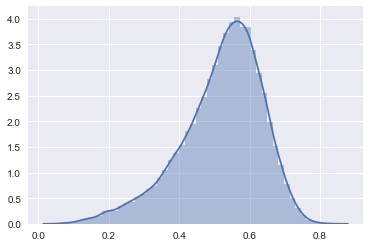

In [244]:
sns.distplot(dev_probs)

In [245]:
list(zip(features, rfc.feature_importances_))

[('hitbin_g_cum', 0.12430337997326001),
 ('hitbin_avg_cum', 0.3063007266771961),
 ('hitbin_avg_p7', 0.0319849017355004),
 ('hitbin_avg_p21', 0.047211821172899696),
 ('pitcher_bats', 0.011653617519911513),
 ('pitcher_g_cum', 0.081435637888307266),
 ('pitcher_avg_cum', 0.1647574049674472),
 ('pitcher_avg_p2', 0.09989128312337632),
 ('pitcher_avg_p5', 0.13246122694210144)]

In [292]:
all_probs = rfc.predict_proba(df[features])[:,1]

In [293]:
df['m2_probs'] = all_probs

In [294]:
df.head()

,date,home,matchup,opp_pitcher,opp_pitcher_lefty,opp_team,own_pitcher,own_pitcher_lefty,team,date_m1,team_fg,opp_team_fg,got_hit,name,model_set,fs_id,hitbin_g_cum,hitbin_avg_cum,hitbin_avg_p7,hitbin_avg_p21,pitcher_bats,pitcher_g_cum,pitcher_avg_cum,pitcher_avg_p2,pitcher_avg_p5,m2_probs
0,2014-09-09,True,Chicago Cubs @ Toronto Blue Jays,Jake Arrieta,False,Chicago Cubs,Mark Buehrle,True,Toronto Blue Jays,2014-09-08,TOR,CHC,True,Edwin Encarnacion,train,0,107.0,0.654206,0.571429,0.571429,0,21.0,0.530291,0.583333,0.558333,0.578345
1,2016-05-09,True,Arizona Diamondbacks @ Colorado Rockies,Archie Bradley,False,Arizona Diamondbacks,Tyler Chatwood,False,Colorado Rockies,2016-05-08,COL,ARI,True,Nolan Arenado,train,1,31.0,0.677419,0.714286,0.666667,1,1.0,0.888889,0.888889,0.888889,0.655927
2,2014-06-07,False,Houston Astros @ Minnesota Twins,Kyle Gibson,False,Minnesota Twins,Scott Feldman,False,Houston Astros,2014-06-06,HOU,MIN,False,Matt Dominguez,train,2,61.0,0.704918,0.714286,0.666667,0,11.0,0.621501,0.722222,0.742857,0.530096
3,2016-08-28,False,Tampa Bay Rays @ Houston Astros,Doug Fister,False,Houston Astros,Chris Archer,False,Tampa Bay Rays,2016-08-27,TBR,HOU,True,Brad Miller,train,4,116.0,0.629310,0.571429,0.714286,0,25.0,0.667111,0.666667,0.700000,0.600355
5,2014-07-06,True,Miami Marlins @ St. Louis Cardinals,Henderson Alvarez,False,Miami Marlins,Marco Gonzales,True,St. Louis Cardinals,2014-07-05,STL,MIA,True,Kolten Wong,train,6,44.0,0.545455,0.285714,0.428571,1,16.0,0.659053,0.555556,0.651111,0.526902


In [295]:
df2 = df[all_probs >= .5]

In [298]:
features = [x for x in df2.columns if x not in not_features]
features = [f for f in features if f != 'm2_probs']
rfc = RandomForestClassifier(n_estimators=100, 
                             min_samples_split=75, 
                             max_features=None, 
                             class_weight='balanced')
dev_probs, rfc = train_model(df2, rfc, features)

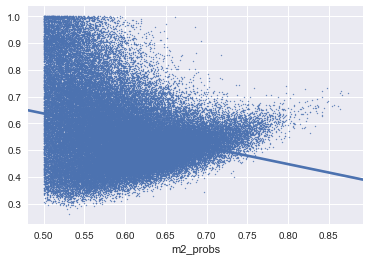

In [301]:
sns.regplot(x=df2.m2_probs, y = rfc.predict_proba(df2[features])[:,1], scatter_kws={'s':2})

In [302]:
df2['m3_probs'] = rfc.predict_proba(df2[features])[:,1]

C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [304]:
features = ['m2_probs', 'm3_probs']
rfc = RandomForestClassifier(n_estimators=100, 
                             min_samples_split=75, 
                             max_features=None, 
                             class_weight='balanced')
dev_probs, rfc = train_model(df2, rfc, features)

In [311]:
m = df.model_set == 'dev'
thresh = np.percentile(dev_probs, 90)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df2[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.353     0.796     0.489     11179
       True      0.604     0.176     0.273     19792

avg / total      0.513     0.400     0.351     30971



C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [283]:
lgr = LogisticRegression(class_weight='balanced')
dev_probs, lgr = train_model(df, lgr, features)

In [281]:
m = df.model_set == 'dev'
thresh = np.percentile(dev_probs, 90)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.349     0.871     0.498     11158
       True      0.533     0.083     0.144     19770

avg / total      0.467     0.367     0.272     30928



In [282]:
thresh

0.77655757209032661

In [266]:
target_percent(df)

93.34

In [273]:
rfc.classes_

array([False,  True], dtype=bool)

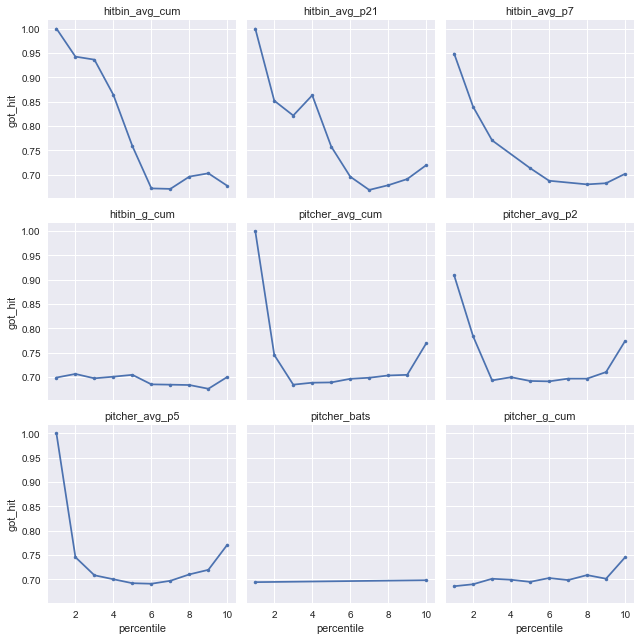

In [231]:
rate_histogram(df, features)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


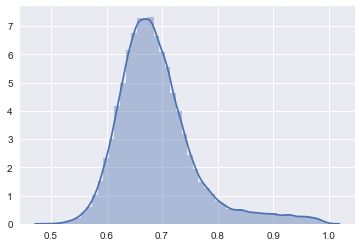

In [230]:
sns.distplot(dev_probs)

In [191]:
df.head(1)

,date,home_x,matchup,opp_pitcher,opp_pitcher_lefty,opp_team,own_pitcher,own_pitcher_lefty,team,date_m1,team_fg,opp_team_fg,got_hit,name,model_set,fs_id,hitbin_g_cum,hitbin_avg_cum,hitbin_avg_p7,hitbin_avg_p21,home_y,pitcher_bats,pitcher_g_cum,pitcher_avg_cum,pitcher_avg_p2,pitcher_avg_p5
0,2014-09-09,True,Chicago Cubs @ Toronto Blue Jays,Jake Arrieta,False,Chicago Cubs,Mark Buehrle,True,Toronto Blue Jays,2014-09-08,TOR,CHC,True,Edwin Encarnacion,train,0,107.0,0.654206,0.571429,0.571429,True,0,21.0,0.530291,0.583333,0.558333


In [175]:
df_hits[df_hits.opp_pitcher == 'Max Scherzer']

,results__Season,name,team_fg,results__G,results__PA,results__AB,results__H,results__1B,results__2B,results__3B,results__HR,results__R,results__RBI,results__BB,results__IBB,results__SO,results__HBP,results__SF,results__SH,results__GDP,results__SB,results__CS,results__AVG,date,hit,opp_pitcher,opp_team_fg,home,hit_pct,pitcher_bats,pitcher_g_cum,pitcher_avg_cum,pitcher_avg_p2,pitcher_avg_p5
1950,2014.0,Juan Uribe,LAD,1.0,4.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,2014-04-08,True,Max Scherzer,DET,True,0.666667,1,NaN,NaN,NaN,NaN
3193,2014.0,Will Venable,SDP,1.0,4.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,2014-04-13,True,Max Scherzer,DET,True,0.555556,1,1.0,0.666667,NaN,NaN
4524,2014.0,Raul Ibanez,LAA,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,2014-04-19,False,Max Scherzer,DET,False,0.444444,0,2.0,0.611111,0.611111,NaN
5822,2014.0,Adam Dunn,CHW,1.0,4.0,4.0,2.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,2014-04-24,True,Max Scherzer,DET,False,0.666667,0,3.0,0.555556,0.500000,NaN
7179,2014.0,Adam Dunn,CHW,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,2014-04-30,False,Max Scherzer,DET,True,0.555556,0,4.0,0.583333,0.555556,NaN
8403,2014.0,Dexter Fowler,HOU,1.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333,2014-05-05,True,Max Scherzer,DET,False,0.333333,0,5.0,0.577778,0.611111,0.577778
9542,2014.0,Joe Mauer,MIN,1.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333,2014-05-10,True,Max Scherzer,DET,False,0.666667,0,6.0,0.537037,0.444444,0.511111
10962,2014.0,David Ortiz,BOS,1.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333,2014-05-16,True,Max Scherzer,DET,True,0.428571,0,7.0,0.555556,0.500000,0.533333
12127,2014.0,Jason Giambi,CLE,1.0,5.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,2014-05-21,True,Max Scherzer,DET,True,0.888889,0,8.0,0.539683,0.547619,0.530159
13711,2014.0,Coco Crisp,OAK,1.0,5.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.200,2014-05-27,True,Max Scherzer,DET,True,0.700000,0,9.0,0.578483,0.658730,0.574603


In [119]:
df_hit_pct.head()

,date,opp_team_fg,hit_pct
0,2014-04-03,ARI,0.555556
1,2014-04-03,BAL,0.888889
2,2014-04-03,BOS,0.555556
3,2014-04-03,CHC,0.500000
4,2014-04-03,CHW,0.666667
